In [1]:
!nvidia-smi

Fri Sep 22 04:03:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q numpy
!pip install -q matplotlib
!pip install -q pandas
!pip install -q tensorflow
!pip install -q scikit-learn
!pip install -q pandas-datareader
!pip install -q yfinance
!pip install --upgrade mplfinance

# Code Source Note: https://github.com/twopirllc/pandas-ta
!pip install -q pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [3]:
import os
import sys
from google.colab import drive
drive.mount('/content/drive/')

# Set the working directory for the tasks
SKELETON_DIR = '/content/drive/MyDrive/stock-prediction/MachineLearning2'
os.chdir(SKELETON_DIR)

Mounted at /content/drive/


In [4]:
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
import pandas_datareader as web
import datetime as dt
import tensorflow as tf
import yfinance as yf
import mplfinance as mpf

from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, SimpleRNN, GRU, InputLayer, Input, Activation
from tensorflow.keras.utils import plot_model

import joblib

In [5]:
start='2015-01-01'
end='2023-09-07'
ticker='TSLA'

# Price Value
price_value = 'Close' # This can be change to 'Open', 'Close', 'Adj Close , 'High', 'Low'

# Split Dataset for Training/Testing
split_ratio=0.8

# Number of look back days to base the prediction
step_size = 30 # Can be changed

# Directory
DATA_DIR = os.path.join(SKELETON_DIR, "data")
PREPARED_DATA_DIR = os.path.join(SKELETON_DIR, "prepared-data")

# File Path
# CSV_FILE = os.path.join(DATA_DIR, f"RawData-from-{start}to-{end}-{ticker}_stock_data.csv")
# PREPARED_DATA_FILE = os.path.join(PREPARED_DATA_DIR, f"PreparedData-from-{start}to-{end}-{ticker}_stock_data.csv")
# PREPARED_TRAIN = os.path.join(PREPARED_DATA_DIR, f"{ticker}_xytrain-from-{start}to-{end}-{ticker}_prepared_data.npz")
# TRAIN_DATA_FILE = os.path.join(PREPARED_DATA_DIR, f"TrainData-from-{start}to-{end}-{ticker}_stock_data.csv")
# TEST_DATA_FILE = os.path.join(PREPARED_DATA_DIR, f"TestData-from-{start}to-{end}-{ticker}_stock_data.csv")
# SCALER_FEATURE_FILE = os.path.join(PREPARED_DATA_DIR, f"FeatureScaler-from-{start}to-{end}-{ticker}.pkl")
# SCALER_TARGET_FILE = os.path.join(PREPARED_DATA_DIR, f"TargetScaler-from-{start}to-{end}-{ticker}.pkl")
# TRAIN_ARRAY_FILE = os.path.join(PREPARED_DATA_DIR, f"{ticker}_xytrain-from-{start}to-{end}_train_arrays.npz")
# TEST_ARRAY_FILE = os.path.join(PREPARED_DATA_DIR, f"{ticker}_xytrain-from-{start}to-{end}_test_arrays.npz")

In [6]:
# Double check directory
def ensure_directory_exists(dir_path):
  # If directory not exist => create
  if not os.path.isdir(dir_path):
      os.mkdir(dir_path)

In [7]:
# Save and Load utility functions
def save_object(obj, filename):
    with open(filename, 'wb') as f:
        joblib.dump(obj, f)

def load_object(filename):
    with open(filename, 'rb') as f:
        return joblib.load(f)

In [8]:
# Load Raw Data
def load_data(start_date, end_date, tick, source='yahoo'):
  ensure_directory_exists(DATA_DIR)
  CSV_FILE = os.path.join(DATA_DIR, f"RawData-from-{start_date}to-{end_date}-{tick}_stock_data.csv")


  # Check if CSV file exists
  # If exist => load
  # If not exist => download
  if os.path.exists(CSV_FILE):
      print('Loading Existing Data')
      data = pd.read_csv(CSV_FILE)
  else:
      print('Downloading Data')
      data = yf.download(tick, start_date, end_date, progress=False)
      data.to_csv(CSV_FILE)

  return data

In [87]:
# Data Validation
def data_validation(start_date, end_date, tick):
  PREPARED_DATA_FILE = os.path.join(PREPARED_DATA_DIR, f"PreparedData-from-{start_date}to-{end_date}-{tick}_stock_data.csv")
  CSV_FILE = os.path.join(DATA_DIR, f"RawData-from-{start_date}to-{end_date}-{tick}_stock_data.csv")
  ensure_directory_exists(PREPARED_DATA_DIR)


  if os.path.exists(PREPARED_DATA_FILE):
      print('Loading Prepared Data')
      df = pd.read_csv(PREPARED_DATA_FILE)
  else:
      print('Processing Raw Data')

      # Read Raw Data File
      df = pd.read_csv(CSV_FILE)

      df['Date'] = pd.to_datetime(df['Date'])

      df.set_index('Date', inplace=True)

      # Adding indicators
      df['RSI']=ta.rsi(df.Close, length=15)
      df['EMAF']=ta.ema(df.Close, length=20)
      df['EMAM']=ta.ema(df.Close, length=100)
      df['EMAS']=ta.ema(df.Close, length=150)

      df['Target'] = df['Adj Close']-df.Open
      df['Target'] = df['Target'].shift(-1)

      df['TargetClass'] = [1 if df.Target[i]>0 else 0 for i in range(len(df))]

      df['TargetNextClose'] = df['Adj Close'].shift(-1)

      # Handle NaN in shifted columns
      df['Target'].fillna(method='ffill', inplace=True)
      df['TargetNextClose'].fillna(method='ffill', inplace=True)

      # Handle NaN in indicators (backfill or forward fill as per your requirement)
      df.fillna(method='bfill', inplace=True)

      # Drop NaN issue in data
      df.dropna(inplace=True)

      # Drop Columns
      # df.drop(['Volume','Close', 'Date'], axis=1, inplace=True)

      # Export Prepared Data
      df.to_csv(PREPARED_DATA_FILE)

  return df

In [10]:
# Split Data by Date or Randomly
def split_data(df, split_ratio, split_by_date=True):
    if split_by_date:
        # Split by date
        train_size = int(len(df) * split_ratio)
        train_data = df.iloc[:train_size]
        test_data = df.iloc[train_size:]
    else:
        # Split Randomly
        train_data, test_data = train_test_split(df, test_size=1-split_ratio, random_state=42)

    print(f"Train Data Shape: {train_data.shape}")
    print(f"Test Data Shape: {test_data.shape}")

    return train_data, test_data


In [11]:
# Scaler
def scaler_features(input_data, scale=True):
    if scale:
        scaler = MinMaxScaler(feature_range=(0, 1))

        # Reshaping if input_data is a Series or 1D numpy array
        if len(input_data.shape) == 1:
            input_data = input_data.values.reshape(-1, 1)

        scaled_data = scaler.fit_transform(input_data)
        return scaled_data, scaler
    else:
        return input_data, None


In [12]:
def create_datasets(start_date, end_date, tick):

    # Download or Load Raw Data
    data = load_data(start_date, end_date, tick)

    # Data Validation
    df = data_validation(start_date, end_date, tick)

    PREPARED_TRAIN = os.path.join(PREPARED_DATA_DIR, f"{tick}_xytrain-from-{start_date}to-{end_date}-{tick}_prepared_data.npz")
    TRAIN_DATA_FILE = os.path.join(PREPARED_DATA_DIR, f"TrainData-from-{start_date}to-{end_date}-{tick}_stock_data.csv")
    TEST_DATA_FILE = os.path.join(PREPARED_DATA_DIR, f"TestData-from-{start_date}to-{end_date}-{tick}_stock_data.csv")
    SCALER_FEATURE_FILE = os.path.join(PREPARED_DATA_DIR, f"FeatureScaler-from-{start_date}to-{end_date}-{tick}.pkl")
    SCALER_TARGET_FILE = os.path.join(PREPARED_DATA_DIR, f"TargetScaler-from-{start_date}to-{end_date}-{tick}.pkl")
    TRAIN_ARRAY_FILE = os.path.join(PREPARED_DATA_DIR, f"{tick}_xytrain-from-{start_date}to-{end_date}_train_arrays.npz")
    TEST_ARRAY_FILE = os.path.join(PREPARED_DATA_DIR, f"{tick}_xytrain-from-{start_date}to-{end_date}_test_arrays.npz")

    if os.path.exists(TRAIN_DATA_FILE) and os.path.exists(TEST_DATA_FILE):
        print('Loading Existing Train and Test Data')
        train_data = pd.read_csv(TRAIN_DATA_FILE)
        test_data = pd.read_csv(TEST_DATA_FILE)

        print(f"Train Data Shape: {train_data.shape}")
        print(f"Test Data Shape: {test_data.shape}")

        # Load feature and target scalers
        train_feature_scaler = load_object(SCALER_FEATURE_FILE)
        train_target_scaler = load_object(SCALER_TARGET_FILE)

        # Load x_train, y_train, x_test, y_test
        train_arrays = np.load(TRAIN_ARRAY_FILE)
        x_train = train_arrays['x_train']
        y_train = train_arrays['y_train']

        test_arrays = np.load(TEST_ARRAY_FILE)
        x_test = test_arrays['x_test']
        y_test = test_arrays['y_test']

    else:
        print('Processing Train and Test Data')
        # Split Data
        train_data, test_data = split_data(df, split_ratio)

        # Define features and target
        feature_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'RSI', 'EMAF', 'EMAM', 'EMAS']
        target_column = 'TargetNextClose'

        # Preparing Train Datasets
        # Scaler for features
        scaled_data_train, train_feature_scaler = scaler_features(train_data[feature_columns])
        # Scaler for target
        scaled_target_train, train_target_scaler = scaler_features(train_data[target_column].values.reshape(-1, 1))

        x_train, y_train = [], []
        for i in range(step_size, len(scaled_data_train)):
            x_train.append(scaled_data_train[i-step_size:i])
            y_train.append(scaled_target_train[i])

        x_train, y_train = np.array(x_train), np.array(y_train)

        # Preparing Test Datasets
        # Use the feature scaler to scale the test data
        scaled_data_test = train_feature_scaler.transform(test_data[feature_columns])
        # Use the target scaler to scale the test target
        scaled_target_test = train_target_scaler.transform(test_data[target_column].values.reshape(-1, 1))

        x_test, y_test = [], []
        for i in range(step_size, len(scaled_data_test)):
            x_test.append(scaled_data_test[i-step_size:i])
            y_test.append(scaled_target_test[i])

        x_test, y_test = np.array(x_test), np.array(y_test)

        # Save train_data and test_data
        train_data.to_csv(TRAIN_DATA_FILE)
        test_data.to_csv(TEST_DATA_FILE)

        # Save feature and target scalers
        save_object(train_feature_scaler, SCALER_FEATURE_FILE)
        save_object(train_target_scaler, SCALER_TARGET_FILE)

        # Save x_train, y_train, x_test, y_test
        np.savez(TRAIN_ARRAY_FILE, x_train=x_train, y_train=y_train)

        np.savez(TEST_ARRAY_FILE, x_test=x_test, y_test=y_test)

    # For data
    if not isinstance(data.index, pd.DatetimeIndex):
        if "Date" in data.columns:
            data['Date'] = pd.to_datetime(data['Date'])
            data.set_index('Date', inplace=True)

    # For df
    if not isinstance(df.index, pd.DatetimeIndex):
        if "Date" in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            df.set_index('Date', inplace=True)

    # For train_data
    if not isinstance(train_data.index, pd.DatetimeIndex):
        if "Date" in train_data.columns:
            train_data['Date'] = pd.to_datetime(train_data['Date'])
            train_data.set_index('Date', inplace=True)

    # For test_data
    if not isinstance(test_data.index, pd.DatetimeIndex):
        if "Date" in test_data.columns:
            test_data['Date'] = pd.to_datetime(test_data['Date'])
            test_data.set_index('Date', inplace=True)


    return data, df, train_data, test_data, train_feature_scaler, train_target_scaler, x_train, x_test, y_train, y_test


In [13]:
data, df, train_data, test_data, train_feature_scaler, train_target_scaler, x_train, x_test, y_train, y_test = create_datasets(start, end, ticker)

Processing Raw Data
Processing Train and Test Data
Train Data Shape: (1627, 13)
Test Data Shape: (407, 13)


In [14]:
print("Data shapes/types:")
print("data:", type(data))
print("df:", type(df))
print("train_data:", train_data.shape)
print("test_data:", test_data.shape)
print("train_feature_scaler:", type(train_feature_scaler))
print("train_target_scaler:", type(train_target_scaler))
print("x_train:", x_train.shape)
print("x_test:", x_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Data shapes/types:
data: <class 'pandas.core.frame.DataFrame'>
df: <class 'pandas.core.frame.DataFrame'>
train_data: (1627, 13)
test_data: (407, 13)
train_feature_scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
train_target_scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
x_train: (1597, 30, 10)
x_test: (377, 30, 10)
y_train: (1597, 1)
y_test: (377, 1)


In [15]:
data.head(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,14.858000,14.883333,14.217333,14.620667,14.620667,71466000
2015-01-05,14.303333,14.433333,13.810667,14.006000,14.006000,80527500
2015-01-06,14.004000,14.280000,13.614000,14.085333,14.085333,93928500


In [16]:
data.tail(3)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-09-01,257.260010,259.079987,242.009995,245.009995,245.009995,132272500
2023-09-05,245.000000,258.000000,244.860001,256.489990,256.489990,129469600
2023-09-06,255.139999,255.389999,245.059998,251.919998,251.919998,116959800


In [17]:
df.head(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,
2015-08-06,16.636000,17.000000,15.741333,16.408667,16.408667,219357000,40.237745,17.562829,16.245100,15.200760,-0.071333,0,16.167334
2015-08-07,16.238667,16.248667,15.892667,16.167334,16.167334,76101000,38.598500,17.429924,16.243561,15.213562,0.199333,1,16.076000
2015-08-10,15.876667,16.198000,15.736667,16.076000,16.076000,62788500,37.971249,17.300979,16.240243,15.224985,0.014667,1,15.824667


In [18]:
df.tail(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,
2023-08-31,255.979996,261.179993,255.050003,258.079987,258.079987,108861700,57.613197,244.661247,232.596473,225.801267,-12.250015,0,245.009995
2023-09-01,257.260010,259.079987,242.009995,245.009995,245.009995,132272500,49.492845,244.694461,232.842285,226.055688,11.489990,1,256.489990
2023-09-05,245.000000,258.000000,244.860001,256.489990,256.489990,129469600,55.407679,245.817845,233.310557,226.458791,-3.220001,0,251.919998


In [19]:
train_data.head(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,
2015-08-06,16.636000,17.000000,15.741333,16.408667,16.408667,219357000,40.237745,17.562829,16.245100,15.200760,-0.071333,0,16.167334
2015-08-07,16.238667,16.248667,15.892667,16.167334,16.167334,76101000,38.598500,17.429924,16.243561,15.213562,0.199333,1,16.076000
2015-08-10,15.876667,16.198000,15.736667,16.076000,16.076000,62788500,37.971249,17.300979,16.240243,15.224985,0.014667,1,15.824667


In [20]:
train_data.tail(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,
2022-01-18,342.203339,356.929993,338.686676,343.503326,343.503326,66743400,47.773035,352.389700,320.618059,300.328648,-15.353333,0,331.883331
2022-01-19,347.236664,351.556671,331.666656,331.883331,331.883331,75442500,44.660152,350.436713,320.841134,300.746591,-4.486664,0,332.089996
2022-01-20,336.576660,347.220001,331.333344,332.089996,332.089996,70488600,44.728781,348.689407,321.063884,301.161735,-17.480011,0,314.633331


In [21]:
test_data.head(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,
2022-01-21,332.113342,334.850006,313.500000,314.633331,314.633331,103416000,40.215277,345.445971,320.936546,301.340167,8.413330,1,310.000000
2022-01-24,301.586670,311.170013,283.823334,310.000000,310.000000,151565700,39.093450,342.070164,320.719981,301.454867,1.399994,1,306.133331
2022-01-25,304.733337,317.086670,301.070007,306.133331,306.133331,86595900,38.142087,338.647609,320.431136,301.516833,-5.006653,0,312.470001


In [22]:
test_data.tail(3)

,Open,High,Low,Close,Adj Close,Volume,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,,
2023-08-31,255.979996,261.179993,255.050003,258.079987,258.079987,108861700,57.613197,244.661247,232.596473,225.801267,-12.250015,0,245.009995
2023-09-01,257.260010,259.079987,242.009995,245.009995,245.009995,132272500,49.492845,244.694461,232.842285,226.055688,11.489990,1,256.489990
2023-09-05,245.000000,258.000000,244.860001,256.489990,256.489990,129469600,55.407679,245.817845,233.310557,226.458791,-3.220001,0,251.919998


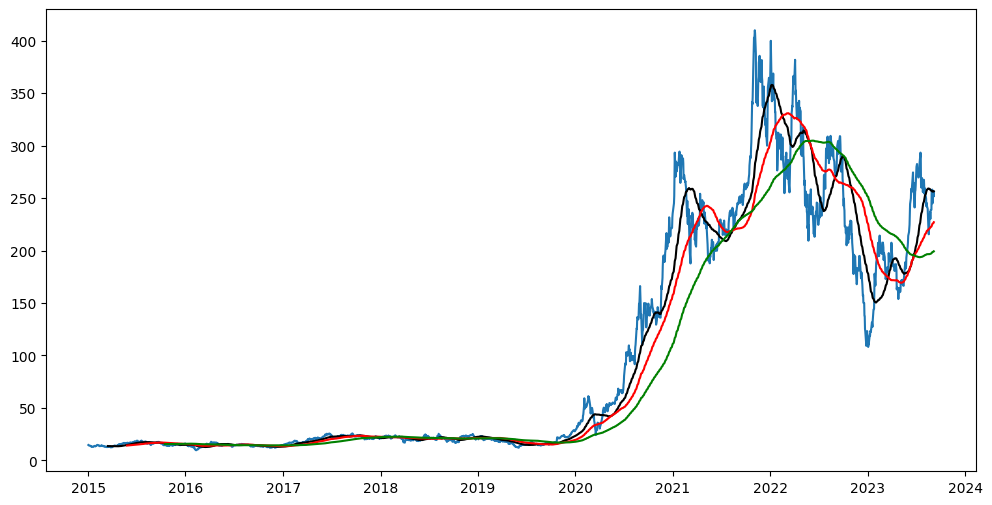

In [23]:
# Moving Avg
ma50 = data[price_value].rolling(50).mean()
ma100 = data[price_value].rolling(100).mean()
ma200 = data[price_value].rolling(200).mean()

# Plot Chart with MA
plt.figure(figsize=(12,6))
plt.plot(data.Close)
plt.plot(ma50, 'k')
plt.plot(ma100,'r')
plt.plot(ma200,'g')

In [24]:
def plot_candlestick(input_df, n=1):

    # Copy to avoid warnings
    input_df = input_df.copy()

    # Resampling the data for n trading days
    if n > 1:
        input_df = input_df.resample(f'{n}D').agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        }).dropna()

    # Add moving averages to the dataframe
    input_df['MA50'] = input_df['Close'].rolling(window=50).mean()
    input_df['MA100'] = input_df['Close'].rolling(window=100).mean()
    input_df['MA200'] = input_df['Close'].rolling(window=200).mean()

    # Create a custom plot for the moving averages
    ap = []
    if input_df['MA50'].dropna().shape[0] > 0:
        aligned_MA50 = input_df['MA50'].dropna().reindex(input_df.index, fill_value=None)
        ap.append(mpf.make_addplot(aligned_MA50, color='orange'))
    if input_df['MA100'].dropna().shape[0] > 0:
        aligned_MA100 = input_df['MA100'].dropna().reindex(input_df.index, fill_value=None)
        ap.append(mpf.make_addplot(aligned_MA100, color='green'))
    if input_df['MA200'].dropna().shape[0] > 0:
        aligned_MA200 = input_df['MA200'].dropna().reindex(input_df.index, fill_value=None)
        ap.append(mpf.make_addplot(aligned_MA200, color='magenta'))

    # Plot the candlestick chart
    mpf.plot(input_df, type='candle', style='charles',
             title=f"{ticker} Candlestick Chart",
             ylabel='Price',
             volume=True,
             ylabel_lower='Volume',
             addplot=ap,
             show_nontrading=True)

In [25]:
def plot_boxplot(input_df, n=1, k=10):
    # Copy to avoid warnings
    input_df = input_df.copy()

    # Resampling the data for n trading days
    if n > 1:
        input_df = input_df.resample(f'{n}D').agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        }).dropna()

    # Prepare data for boxplot
    box_data = []
    labels = []
    for idx, row in input_df.iterrows():
        box_data.append([row['Low'], row['Open'], row['Close'], row['High']])
        labels.append(idx.strftime('%Y-%m-%d'))

    # Plotting
    fig, ax = plt.subplots()
    ax.boxplot(box_data, vert=True, patch_artist=True)
    ax.set_title(f'{ticker} Boxplot Chart')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')

    # Set x-axis labels and ticks
    ax.set_xticks(range(1, len(labels) + 1, k))
    ax.set_xticklabels(labels[::k], rotation=90)

    plt.show()

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


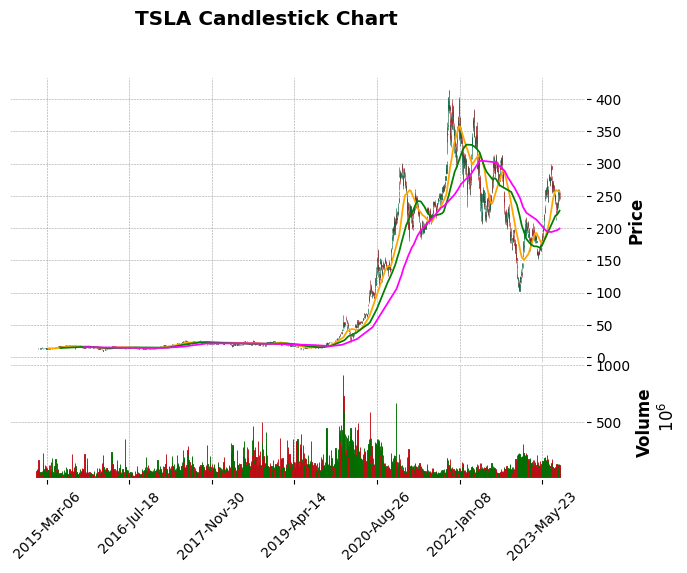

In [26]:
plot_candlestick(data)

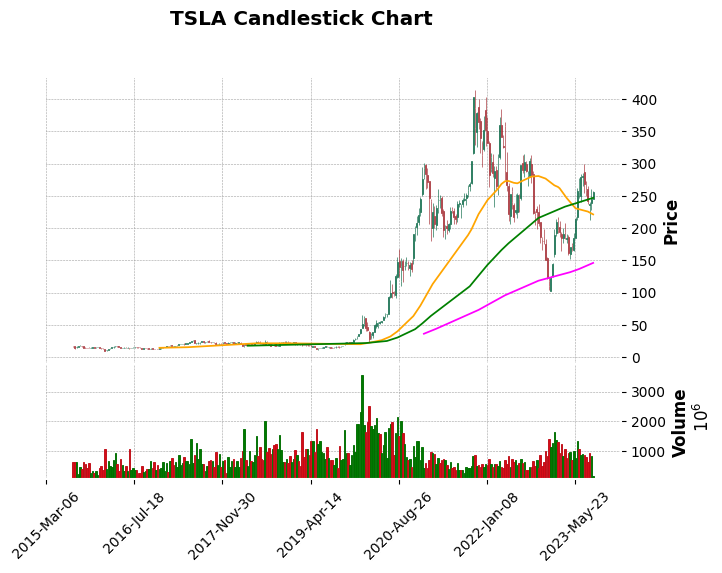

In [27]:
plot_candlestick(df, n=10)

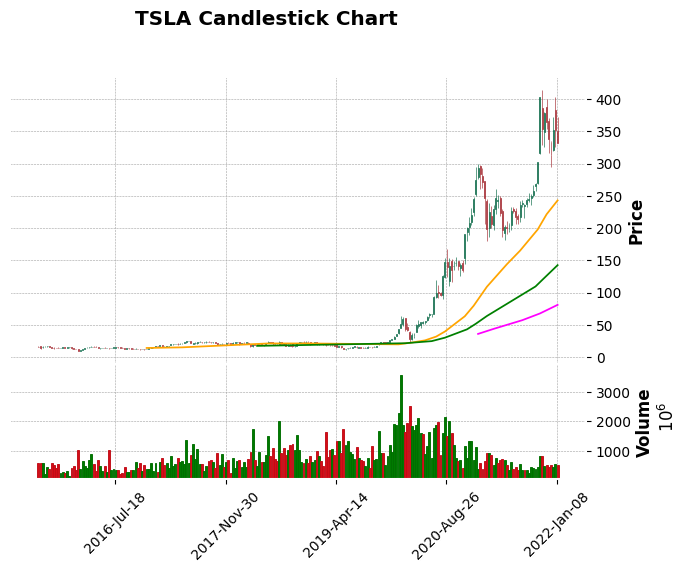

In [28]:
plot_candlestick(train_data,n=10)

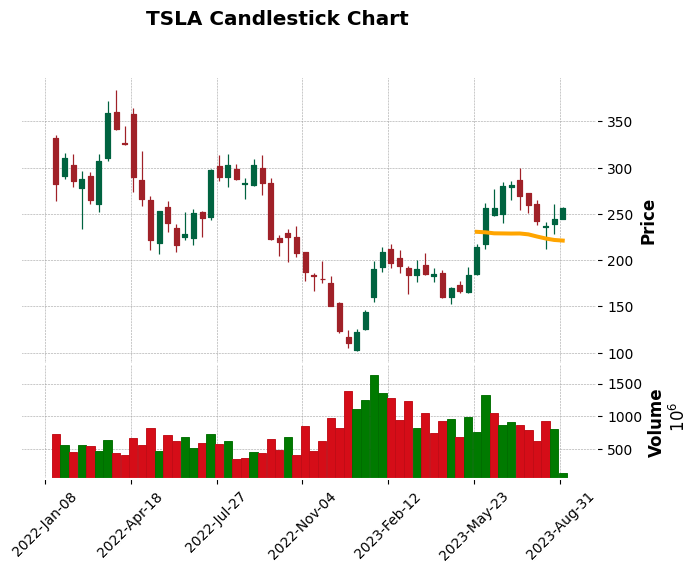

In [29]:
plot_candlestick(test_data,n=10)

In [30]:
def create_dynamic_model(input_shape, layer_configs, output_units=1):
    model = Sequential()

    # First layer needs to specify input_shape
    first_layer_config = layer_configs[0]
    layer_type = first_layer_config['type']

    if 'Bidirectional' in layer_type:
        layer_type = layer_type.replace('Bidirectional(', '').replace(')', '')
        if layer_type == 'LSTM':
            model.add(Bidirectional(LSTM(units=first_layer_config['units'], return_sequences=first_layer_config['return_sequences']), input_shape=input_shape))
        elif layer_type == 'GRU':
            model.add(Bidirectional(GRU(units=first_layer_config['units'], return_sequences=first_layer_config['return_sequences']), input_shape=input_shape))
        elif layer_type == 'RNN':
            model.add(Bidirectional(SimpleRNN(units=first_layer_config['units'], return_sequences=first_layer_config['return_sequences']), input_shape=input_shape))
    else:
        if layer_type == 'LSTM':
            model.add(LSTM(units=first_layer_config['units'], return_sequences=first_layer_config['return_sequences'], input_shape=input_shape))
        elif layer_type == 'GRU':
            model.add(GRU(units=first_layer_config['units'], return_sequences=first_layer_config['return_sequences'], input_shape=input_shape))
        elif layer_type == 'RNN':
            model.add(SimpleRNN(units=first_layer_config['units'], return_sequences=first_layer_config['return_sequences'], input_shape=input_shape))

    if 'activation' in first_layer_config:
        model.add(Activation(first_layer_config['activation']))

    model.add(Dropout(first_layer_config['dropout']))

    # Remaining layers
    for layer_config in layer_configs[1:]:
        layer_type = layer_config['type']

        if 'Bidirectional' in layer_type:
            layer_type = layer_type.replace('Bidirectional(', '').replace(')', '')
            if layer_type == 'LSTM':
                model.add(Bidirectional(LSTM(units=layer_config['units'], return_sequences=layer_config['return_sequences']), input_shape=input_shape))
            elif layer_type == 'GRU':
                model.add(Bidirectional(GRU(units=layer_config['units'], return_sequences=layer_config['return_sequences']), input_shape=input_shape))
            elif layer_type == 'RNN':
                model.add(Bidirectional(SimpleRNN(units=layer_config['units'], return_sequences=layer_config['return_sequences']), input_shape=input_shape))
        else:
            if layer_type == 'LSTM':
                model.add(LSTM(units=layer_config['units'], return_sequences=layer_config['return_sequences']))
            elif layer_type == 'GRU':
                model.add(GRU(units=layer_config['units'], return_sequences=layer_config['return_sequences']))
            elif layer_type == 'RNN':
                model.add(SimpleRNN(units=layer_config['units'], return_sequences=layer_config['return_sequences']))

        if 'activation' in layer_config:
            model.add(Activation(layer_config['activation']))

        model.add(Dropout(layer_config['dropout']))

    # Output layer
    model.add(Dense(units=output_units))

    return model

In [31]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = model_training_history.history[metric_name_1]
  metric_value_2 = model_training_history.history[metric_name_2]

  # Constructing a range object which will be used as time
  epochs = range(len(metric_value_1))

  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()

In [32]:
n_steps = x_train.shape[1]
print(n_steps)
n_features = x_train.shape[2]
print(n_features)
input_shape = (n_steps, n_features)

30
10


In [ ]:
# Test 1 - Mix LSTM, GRU, RNN, Differs Activation
layer_configs = [
    { 'type': 'LSTM', 'units': 120, 'return_sequences': True, 'dropout': 0.25, 'activation': 'tanh' },
    { 'type': 'LSTM', 'units': 100, 'return_sequences': True, 'dropout': 0.25 },
    { 'type': 'GRU', 'units': 80, 'return_sequences': True, 'dropout': 0.25 },
    { 'type': 'RNN', 'units': 60, 'return_sequences': True, 'dropout': 0.25, 'activation': 'relu' },
    { 'type': 'LSTM', 'units': 40, 'return_sequences': False, 'dropout': 0.25 }
]

In [ ]:
# Test 2 - Simple LSTM Model
layer_configs = [
    { 'type': 'LSTM', 'units': 50, 'return_sequences': True, 'dropout': 0.2 },
    { 'type': 'LSTM', 'units': 50, 'return_sequences': False, 'dropout': 0.2 }
]

In [ ]:
# Test 3 - Simple GRU Model (Most Accurate)
layer_configs = [
    { 'type': 'GRU', 'units': 100, 'return_sequences': True, 'dropout': 0.2 },
    { 'type': 'GRU', 'units': 100, 'return_sequences': False, 'dropout': 0.2 }
]

In [ ]:
# Test 4 - More complex GRU Model
layer_configs = [
    { 'type': 'GRU', 'units': 128, 'return_sequences': True, 'dropout': 0.2 },
    { 'type': 'GRU', 'units': 128, 'return_sequences': True, 'dropout': 0.2 },
    { 'type': 'GRU', 'units': 128, 'return_sequences': False, 'dropout': 0.2 }
]

In [ ]:
# Test 5 - Mixed LSTM and GRU Model
layer_configs = [
    { 'type': 'LSTM', 'units': 100, 'return_sequences': True, 'dropout': 0.2 },
    { 'type': 'GRU', 'units': 100, 'return_sequences': False, 'dropout': 0.2 }
]

In [ ]:
# Test 6 - Deep LSTM with more Units Model
layer_configs = [
    { 'type': 'LSTM', 'units': 200, 'return_sequences': True, 'dropout': 0.2 },
    { 'type': 'LSTM', 'units': 150, 'return_sequences': True, 'dropout': 0.2 },
    { 'type': 'LSTM', 'units': 100, 'return_sequences': False, 'dropout': 0.2 }
]

In [ ]:
# Test 7 - LTSM Reduced Dropout Model
layer_configs = [
    { 'type': 'LSTM', 'units': 100, 'return_sequences': True, 'dropout': 0.1 },
    { 'type': 'LSTM', 'units': 100, 'return_sequences': False, 'dropout': 0.1 }
]

In [ ]:
# Test 8 -  Complex Bidirectional LSTM Configuration Model
layer_configs = [
    { 'type': 'Bidirectional(LSTM)', 'units': 128, 'return_sequences': True, 'dropout': 0.2 },
    { 'type': 'Bidirectional(LSTM)', 'units': 128, 'return_sequences': True, 'dropout': 0.2 },
    { 'type': 'Bidirectional(LSTM)', 'units': 128, 'return_sequences': True, 'dropout': 0.2 },
    { 'type': 'Bidirectional(LSTM)', 'units': 128, 'return_sequences': False, 'dropout': 0.2 }
]

In [ ]:
# Test 9 -  Complex Bidirectional GRU Configuration Model
layer_configs = [
    { 'type': 'Bidirectional(GRU)', 'units': 128, 'return_sequences': True, 'dropout': 0.3 },
    { 'type': 'Bidirectional(GRU)', 'units': 128, 'return_sequences': True, 'dropout': 0.3 },
    { 'type': 'Bidirectional(GRU)', 'units': 64, 'return_sequences': True, 'dropout': 0.2 },
    { 'type': 'Bidirectional(GRU)', 'units': 64, 'return_sequences': False, 'dropout': 0.2 }
]

In [33]:
# Test 10 - Complex Bidirectional GRU Configuration - More Layers Model
layer_configs = [
    { 'type': 'Bidirectional(GRU)', 'units': 256, 'return_sequences': True, 'dropout': 0.4 },
    { 'type': 'Bidirectional(GRU)', 'units': 128, 'return_sequences': True, 'dropout': 0.3 },
    { 'type': 'Bidirectional(GRU)', 'units': 128, 'return_sequences': True, 'dropout': 0.3 },
    { 'type': 'Bidirectional(GRU)', 'units': 64, 'return_sequences': True, 'dropout': 0.2 },
    { 'type': 'Bidirectional(GRU)', 'units': 32, 'return_sequences': False, 'dropout': 0.1 }
]

In [ ]:
del model

In [34]:
model = create_dynamic_model(input_shape, layer_configs)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 30, 512)           411648    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 30, 512)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 30, 256)           493056    
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 30, 256)           0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 30, 256)           296448    
 onal)                                                           
                                                        

In [35]:
# Training
# Avoid overfitting by using early_stopping, dropout, etc
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)
model.compile(loss='mse', optimizer='adam', metrics=["accuracy"])
model_training_history = model.fit(x_train, y_train, batch_size=32, epochs=100, shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/100
40/40 [==============================] - 33s 115ms/step - loss: 0.0086 - accuracy: 7.8309e-04 - val_loss: 0.0044 - val_accuracy: 0.0031
Epoch 2/100
40/40 [==============================] - 1s 26ms/step - loss: 3.5583e-04 - accuracy: 7.8309e-04 - val_loss: 0.0078 - val_accuracy: 0.0031
Epoch 3/100
40/40 [==============================] - 1s 24ms/step - loss: 2.8970e-04 - accuracy: 7.8309e-04 - val_loss: 0.0061 - val_accuracy: 0.0031
Epoch 4/100
40/40 [==============================] - 1s 26ms/step - loss: 2.7746e-04 - accuracy: 7.8309e-04 - val_loss: 0.0035 - val_accuracy: 0.0031
Epoch 5/100
40/40 [==============================] - 1s 24ms/step - loss: 3.1720e-04 - accuracy: 7.8309e-04 - val_loss: 0.0067 - val_accuracy: 0.0031
Epoch 6/100
40/40 [==============================] - 1s 24ms/step - loss: 2.8617e-04 - accuracy: 7.8309e-04 - val_loss: 0.0045 - val_accuracy: 0.0031
Epoch 7/100
40/40 [==============================] - 1s 24ms/step - loss: 2.9516e-04 - accuracy: 7.830

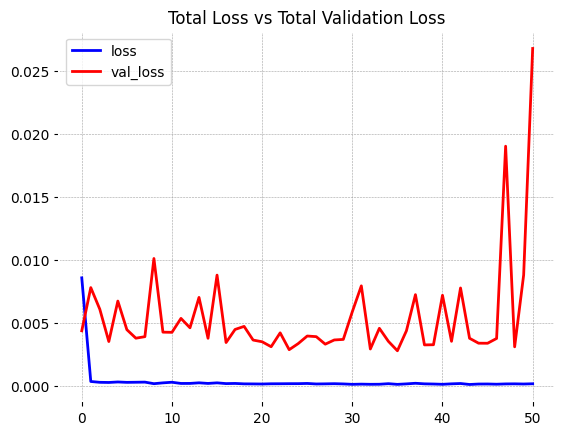

In [36]:
# Plot Total Loss vs Total Validation Loss
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')

In [37]:
# Model coded added before for testing, won't be available in this submission.
predicted_prices = model.predict(x_test)
predicted_prices = train_target_scaler.inverse_transform(predicted_prices)

12/12 [==============================] - 3s 12ms/step


In [ ]:
print(predicted_prices)

In [39]:
print(type(train_data))
print(type(test_data))
print(type(predicted_prices))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [40]:
def plot_candlestick_predicted(input_df, predicted_prices, n=1):
    # Work with a deep copy to avoid modifying the original dataframe
    input_df = input_df.copy()

    # Resampling the data for n trading days
    if n > 1:
        input_df = input_df.resample(f'{n}D').agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        }).dropna()

    # Add moving averages to the dataframe
    input_df['MA50'] = input_df[price_value].rolling(window=50).mean()
    input_df['MA100'] = input_df[price_value].rolling(window=100).mean()
    input_df['MA200'] = input_df[price_value].rolling(window=200).mean()

    # Convert the index to a DatetimeIndex
    input_df.index = pd.to_datetime(input_df.index)

    # Plot the last the last predicted candles
    df_plot = input_df[-len(predicted_prices):].copy()

    # Add Predicted Prices
    # Check if predicted_prices is 2D and reshape if necessary
    if predicted_prices.ndim == 2:
        predicted_prices = predicted_prices.reshape(-1)

    # Ensure the length of predicted_prices
    # matches the length of the sliced portion of the DataFrame
    if len(predicted_prices) > len(df_plot):
        predicted_prices = predicted_prices[-len(df_plot):]  # Take only the last predictions
    elif len(predicted_prices) < len(df_plot):
        print(f"Length mismatch: predicted_prices has length {len(predicted_prices)} but df_plot has length {len(df_plot)}")
        # Align the predictions to the end of df_plot
        start_idx = len(df_plot) - len(predicted_prices)
        df_plot = df_plot[start_idx:].copy()

    df_plot['Predicted'] = predicted_prices

    # Create a custom plot for the predicted prices
    ap = []
    if input_df['MA50'].dropna().shape[0] > 0:
        aligned_MA50 = input_df['MA50'].dropna().reindex(input_df.index, fill_value=None)
        ap.append(mpf.make_addplot(aligned_MA50, color='orange'))
    if input_df['MA100'].dropna().shape[0] > 0:
        aligned_MA100 = input_df['MA100'].dropna().reindex(input_df.index, fill_value=None)
        ap.append(mpf.make_addplot(aligned_MA100, color='green'))
    if input_df['MA200'].dropna().shape[0] > 0:
        aligned_MA200 = input_df['MA200'].dropna().reindex(input_df.index, fill_value=None)
        ap.append(mpf.make_addplot(aligned_MA200, color='magenta'))

    ap.append(mpf.make_addplot(df_plot['Predicted'], color='red', linestyle='dashed'))

    # Plot the candlestick chart
    mpf.plot(df_plot, type='candle', style='charles',
             title=f"{ticker}Candlestick Chart",
             ylabel='Price',
             volume=False,
             addplot=ap,
             show_nontrading=False)

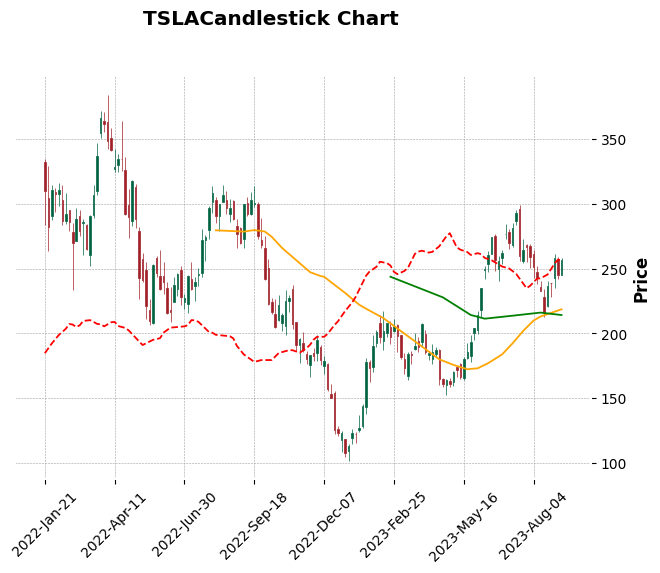

In [41]:
plot_candlestick_predicted(test_data, predicted_prices, n=4)

In [42]:
def plot_candlestick_full(train_df, test_df, predicted_prices, n=1):
    # Create deep copies to avoid modifying the original dataframes
    train_df = train_df.copy()
    test_df = test_df.copy()

    # Resampling the data for n trading days
    if n > 1:
        train_df = train_df.resample(f'{n}D').agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        }).dropna()

        test_df = test_df.resample(f'{n}D').agg({
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        }).dropna()

        if train_df.empty or test_df.empty:
          raise ValueError("Resampling resulted in an empty DataFrame. Try a smaller value of n.")

        # Adjust the length of predicted_prices to match test_df
        eff_length = len(test_df)
        predicted_prices = predicted_prices[-eff_length:]

    # Compute moving averages for the training data
    train_df['MA50'] = train_df[price_value].rolling(window=50).mean()
    train_df['MA100'] = train_df[price_value].rolling(window=100).mean()
    train_df['MA200'] = train_df[price_value].rolling(window=200).mean()

    # Compute moving averages for the test data
    test_df['MA50'] = test_df[price_value].rolling(window=50).mean()
    test_df['MA100'] = test_df[price_value].rolling(window=100).mean()
    test_df['MA200'] = test_df[price_value].rolling(window=200).mean()

    # Check if predicted_prices is 2D and reshape if necessary
    if predicted_prices.ndim == 2:
        predicted_prices = predicted_prices.reshape(-1)

    # Ensure the length of predicted_prices matches the length of the test data
    if len(predicted_prices) != len(test_df):
        raise ValueError(f"Length mismatch: predicted_prices has length {len(predicted_prices)} but test_df has length {len(test_df)}")

    # Add predicted prices to the test dataframe
    test_df['Predicted'] = predicted_prices

    # Concatenate train and test dataframes to form a complete dataframe for plotting
    df_plot = pd.concat([train_df, test_df])

    # Convert the index to a DatetimeIndex
    df_plot.index = pd.to_datetime(df_plot.index)

    # Create a custom plot for the predicted prices and moving averages
    ap = []
    if df_plot['MA50'].dropna().shape[0] > 0:
        aligned_MA50 = df_plot['MA50'].dropna().reindex(df_plot.index, fill_value=None)
        ap.append(mpf.make_addplot(aligned_MA50, color='orange'))

    if df_plot['MA100'].dropna().shape[0] > 0:
        aligned_MA100 = df_plot['MA100'].dropna().reindex(df_plot.index, fill_value=None)
        ap.append(mpf.make_addplot(aligned_MA100, color='green'))

    if df_plot['MA200'].dropna().shape[0] > 0:
        aligned_MA200 = df_plot['MA200'].dropna().reindex(df_plot.index, fill_value=None)
        ap.append(mpf.make_addplot(aligned_MA200, color='magenta'))

    ap.append(mpf.make_addplot(df_plot['Predicted'], color='red', linestyle='dashed'))

    # Plot the candlestick chart
    mpf.plot(df_plot, type='candle', style='charles',
            title=f"{ticker} Candlestick Chart",
            ylabel='Price',
            volume=False,
            addplot=ap,
            show_nontrading=False)


/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


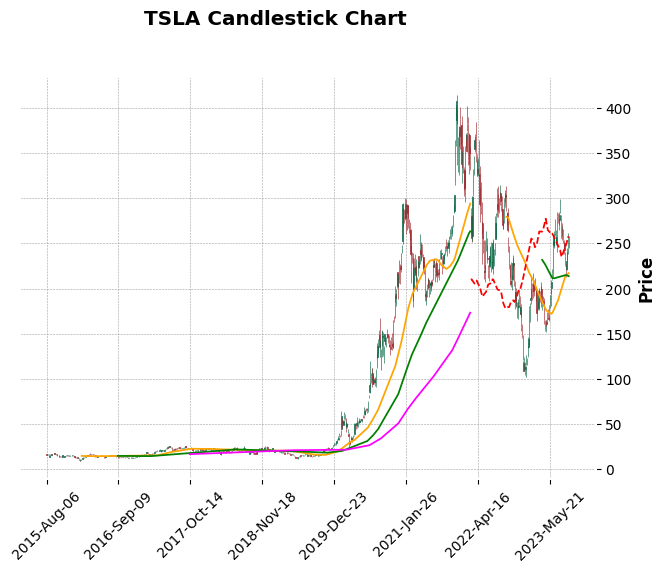

In [43]:
# Truncate or slice test_df to match the length of predicted_prices
truncated_test_data = test_data.iloc[-len(predicted_prices):]
plot_candlestick_full(train_data,truncated_test_data, predicted_prices, n=4)

In [44]:
del data, df, train_data, test_data, train_feature_scaler, train_target_scaler, x_train, x_test, y_train, y_test

# create_predict_datasets

**The function `create_predict_datasets` takes the following parameters:**

1. `start_predict`: A string representing the starting date for the dataset.
2. `end_predict`: A string representing the ending date for the dataset.
3. `tick`: A string representing the ticker symbol of the company's stock.
4. `k`: An integer representing the number of days into the future for which predictions need to be made.

**This function performs the following operations:**

1. **Load Raw Data**: Retrieves the stock data for the given ticker and date range.
2. **Data Validation**: Validates the data to ensure its integrity.
3. **Features and Target Definition**: Specifies the columns to be used as features and the target column for prediction.
4. **Data Scaling**: Scales the feature and target data using a scaler to normalize the values.
5. **Test Data Creation**: Generates the x_test and y_test datasets based on the scaled data.
6. **Date Indexing**: Ensures that the data is indexed by the date column for easy retrieval and organization.


In [76]:
def create_predict_datasets(start_predict, end_predict, tick, k):

    # Download or Load Raw Data
    print(f"Fetching data from {start_predict} to {end_predict}")
    data = load_data(start_predict, end_predict, tick)

    print(f"Raw data shape: {data.shape}")
    print(data.head())

    # Data Validation
    df = data_validation(start_predict, end_predict, tick)

    print(f"Processed data shape: {df.shape}")
    print(df.head())

    # Define features and target
    feature_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'RSI', 'EMAF', 'EMAM', 'EMAS']
    target_column = 'TargetNextClose'

    # Preparing Datasets
    # Scaler for features
    scaled_data, train_feature_scaler = scaler_features(df[feature_columns])
    print("Scaled data shape:", scaled_data.shape)

    # Scaler for target
    scaled_target_train, scaler = scaler_features(df[target_column].values.reshape(-1, 1))

    x_test, y_test = [], []
    for i in range(step_size, len(scaled_data)):
        x_test.append(scaled_data[i-step_size:i])
        y_test.append(scaled_target_train[i])

    x_test, y_test = np.array(x_test), np.array(y_test)
    print("x_test shape:", x_test.shape)

    # For data
    if not isinstance(data.index, pd.DatetimeIndex):
        if "Date" in data.columns:
            data['Date'] = pd.to_datetime(data['Date'])
            data.set_index('Date', inplace=True)

    # For df
    if not isinstance(df.index, pd.DatetimeIndex):
        if "Date" in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            df.set_index('Date', inplace=True)


    return df, scaled_data, scaler, x_test, y_test


In [78]:
def plot_predictions(df, actual_prices, past_predictions, future_predictions):
    # Flatten future_predictions to 1D
    future_predictions = future_predictions.flatten()

    # Generate date sequences for plotting
    actual_dates = df.index
    future_dates = pd.date_range(start=actual_dates[-1], periods=len(future_predictions)+1)[1:]

    plt.figure(figsize=(15, 7))

    # Plot actual and past predicted prices
    plt.plot(actual_dates, actual_prices, color='blue', label='Actual Prices')
    plt.plot(actual_dates[-len(past_predictions):], past_predictions, color='green', label='Past Predictions')

    # Plot future predictions
    plt.plot(future_dates, future_predictions, color='red', linestyle='dashed', label='Future Predictions')

    plt.title('Stock Price Predictions')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## `single_day_multivariate_prediction`

**The function `single_day_multivariate_prediction` takes the following parameters:**

1. `model`: A pre-trained machine learning or deep learning model that will be used for prediction.
2. `tick`: A string representing the stock ticker symbol for which the prediction is to be made.
3. `predict_date`: A string representing the date for which the prediction is to be made in the format 'YYYY-MM-DD'.

**This function performs the following operations:**

1. **Date Conversion**: Converts the `predict_date` string into a datetime object for further operations.
2. **Lookback Calculation**: Determines the starting date (2 years prior to `predict_date`) for fetching historical stock data.
3. **Data Preparation**: Calls the `create_predict_datasets` function to fetch and prepare the necessary datasets for prediction. The data fetched starts from the calculated lookback date and ends a day before the specified `predict_date`.
4. **Data Availability Check**: Verifies if there's sufficient data available to make a prediction. If not, a `ValueError` is raised.
5. **Prediction**: Uses the provided `model` to make a prediction using the last day's multivariate data fetched.
6. **Inverse Scaling**: The raw prediction output from the model is scaled back to its original range using the inverse transformation process to get the actual predicted price.
7. **Output**: The function returns the predicted closing price for the specified `predict_date`.

In [147]:
def single_day_multivariate_prediction(model, tick, predict_date):

    # Convert the string date to a datetime object
    predict_date = datetime.strptime(predict_date, '%Y-%m-%d')
    start_date = predict_date - timedelta(days=730)

    print(f"Date: {start_date.strftime('%Y-%m-%d')} to {predict_date.strftime('%Y-%m-%d')}")

    # Create a dataset from the start date to the day before the specified prediction date
    _, scaled_data, scaler, x_test, _ = create_predict_datasets(start_date.strftime('%Y-%m-%d'), predict_date.strftime('%Y-%m-%d'), tick, k=1)

    # Check if there's enough data for prediction
    if len(x_test) == 0 or x_test[-1].shape[0] == 0:
        raise ValueError("Insufficient data for the specified prediction date.")

    # Use the model to make a prediction using the last day's multivariate data
    prediction = model.predict(x_test[-1].reshape(1, -1, x_test.shape[-1]))

    # Inversely scale the prediction to get the actual predicted price
    predicted_price = scaler.inverse_transform(prediction)

    print(f"Date: {predict_date.strftime('%Y-%m-%d')}, Predicted Price: {predicted_price[0][0]}")

    return predicted_price


In [148]:
end_date = '2023-09-22'
predicted_closing_price = single_day_multivariate_prediction(model,
                                                             tick='TSLA',
                                                             predict_date=end_date)


Date: 2021-09-22 to 2023-09-22
Fetching data from 2021-09-22 to 2023-09-22
Loading Existing Data
Raw data shape: (503, 7)
         Date        Open        High         Low       Close   Adj Close  \
0  2021-09-22  247.843338  251.223328  246.373337  250.646667  250.646667   
1  2021-09-23  251.666672  252.733337  249.306671  251.213333  251.213333   
2  2021-09-24  248.630005  258.266663  248.186661  258.130005  258.130005   
3  2021-09-27  257.706665  266.333344  256.436676  263.786682  263.786682   
4  2021-09-28  262.399994  265.213318  255.393326  259.186676  259.186676   

     Volume  
0  45378900  
1  35842500  
2  64119000  
3  84212100  
4  76144200  
Loading Prepared Data
Processed data shape: (503, 14)
         Date        Open        High         Low       Close   Adj Close  \
0  2021-09-22  247.843338  251.223328  246.373337  250.646667  250.646667   
1  2021-09-23  251.666672  252.733337  249.306671  251.213333  251.213333   
2  2021-09-24  248.630005  258.266663  248.186


# predictions

**The function `predictions` takes the following parameters:**

1. `model`: A pre-trained machine learning model used for making predictions.
2. `tick`: A string representing the ticker symbol of the company's stock.
3. `start_predict`: A string representing the starting date for the dataset.
4. `end_predict`: A string representing the ending date for the dataset.
5. `k`: An integer representing the number of days into the future for which predictions need to be made (default value is 10).

**This function performs the following operations:**

1. **Prepare Datasets**: Calls `create_predict_datasets` to prepare the required datasets for prediction.
2. **Past Predictions**: Uses the model to predict past closing prices based on the test dataset.
3. **Future Predictions**: Predicts the closing prices for the next \( k \) days using the model.
4. **Date Handling**: Generates future dates based on the last known date in the dataset.
5. **Prediction Printing**: Prints each future prediction along with its corresponding date.

In [141]:
def predictions(model, tick, start_predict, end_predict, k=10):

  print(f'Date: {start_predict} to {end_predict}')

  # Preparing Datasets
  predict_df, scaled_data, scaler, x_test, y_test = create_predict_datasets(start_predict, end_predict, tick, k)

  # Actual Prices
  actual_prices = predict_df['Close'].values

  # Past predictions
  past_predictions = model.predict(x_test)
  past_predictions = scaler.inverse_transform(past_predictions)

  # Convert to numpy
  past_predictions = np.array(past_predictions)

  # Placeholder for future predictions of company
  future_days = k
  future_predictions = []

  input_data = x_test[-1]

  # Getting the last known date from the dataset and generating future dates
  last_known_date = datetime.strptime(end_predict, '%Y-%m-%d')
  future_dates = [last_known_date + timedelta(days=i) for i in range(1, future_days + 1)]

  for i in range(future_days):
    pred = model.predict(input_data.reshape(1, -1, x_test.shape[-1]))

    # Inversely scaling
    predicted_price = scaler.inverse_transform(pred)

    future_predictions.append(predicted_price)

    # Print predictions
    current_date = future_dates[i]
    print(f"Date: {current_date.strftime('%Y-%m-%d')}, Predicted Price: {predicted_price}")

    # Updating the last element with the new prediction
    input_data = np.roll(input_data, -1, axis=0)
    input_data[-1] = pred

  # Convert to numpy
  future_predictions = np.array(future_predictions)

  return predict_df, actual_prices, past_predictions, future_predictions


In [142]:
end_date = datetime.now()
start_date = end_date - timedelta(days=730)
predict_df, actual_prices, past_predictions, future_predictions = predictions(model,
                                                                  tick='TSLA',
                                                                  start_predict=start_date.strftime('%Y-%m-%d'),
                                                                  end_predict=end_date.strftime('%Y-%m-%d'),
                                                                  k=10)

Date: 2021-09-22 to 2023-09-22
Fetching data from 2021-09-22 to 2023-09-22
Loading Existing Data
Raw data shape: (503, 7)
         Date        Open        High         Low       Close   Adj Close  \
0  2021-09-22  247.843338  251.223328  246.373337  250.646667  250.646667   
1  2021-09-23  251.666672  252.733337  249.306671  251.213333  251.213333   
2  2021-09-24  248.630005  258.266663  248.186661  258.130005  258.130005   
3  2021-09-27  257.706665  266.333344  256.436676  263.786682  263.786682   
4  2021-09-28  262.399994  265.213318  255.393326  259.186676  259.186676   

     Volume  
0  45378900  
1  35842500  
2  64119000  
3  84212100  
4  76144200  
Loading Prepared Data
Processed data shape: (503, 14)
         Date        Open        High         Low       Close   Adj Close  \
0  2021-09-22  247.843338  251.223328  246.373337  250.646667  250.646667   
1  2021-09-23  251.666672  252.733337  249.306671  251.213333  251.213333   
2  2021-09-24  248.630005  258.266663  248.186